In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

In [11]:
def ESN(data, first_steps, train_length, test_length, nr_reservoir, spectral_radius, reg_coefficient, seed=42):
    np.random.seed(seed)
    Nu = 1 
    Win = np.random.uniform(-1, 1, (nr_reservoir, Nu + 1)) * 0.2
    W = np.random.uniform(-1, 1, (nr_reservoir, nr_reservoir))
    rhoW = max(abs(linalg.eig(W)[0]))
    W *= spectral_radius / rhoW

    X = np.zeros((1 + Nu + nr_reservoir, train_length - first_steps))
    Yt = data[None, first_steps+1:train_length+1]

    x = np.zeros((nr_reservoir, 1))
    for t in range(train_length):
        u = data[t]
        x = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
        if t >= first_steps:
            X[:, t - first_steps] = np.vstack((1, u, x))[:, 0]

    Wout = linalg.solve(np.dot(X, X.T) + reg_coefficient * np.eye(1 + Nu + nr_reservoir), np.dot(X, Yt.T)).T

    # Run the trained ESN in a generative mode
    Y = np.zeros((1, test_length))
    u = data[train_length]
    for t in range(test_length):
        x = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
        y = np.dot(Wout, np.vstack((1, u, x)))
        Y[:, t] = y
        u = y

    # Compute MSE for the test time steps
    mse = sum(np.square(data[train_length:train_length+test_length] - Y[0, :])) / test_length

    return Wout, Y, mse

In [12]:
def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements


In [13]:
def sinusoidal_signal_sim():
    train_length = 3000
    test_length = 1000
    nr_reservoir = 1000
    spectral_radius = 0.8
    reg_coefficient = 1e-8

    # Generate signal
    n = np.arange(1, 4001)
    data = 0.5 * np.sin(n / 4)

    # Run ESN model
    Wout, Y, mse = ESN(
        data, 
        first_steps=1000, 
        train_length=train_length,
        test_length=test_length, 
        nr_reservoir=nr_reservoir,
        spectral_radius=spectral_radius, 
        reg_coefficient=reg_coefficient
    )

    # Plot the result
    plt.figure()
    plt.plot(data[train_length:train_length+test_length], label="Ground truth")
    plt.plot(Y.flatten(), label="ESN prediction")
    plt.legend()
    plt.title('ESN Model Prediction vs Ground Truth for Sinusoidal Signal')
    plt.show()

    print(f"Mean Squared Error for the sinusoidal signal: {mse}")

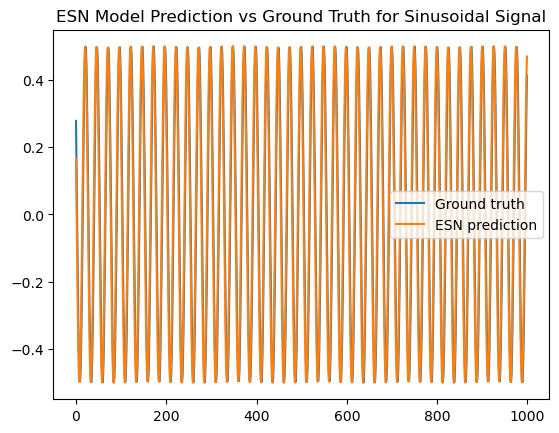

Mean Squared Error for the sinusoidal signal: 0.007796469454973687


In [14]:
sinusoidal_signal_sim()

In [15]:
def mackey_glass_sim():
    train_length = 3000
    test_length = 1000
    nr_reservoir = 1000
    spectral_radius = 0.8
    reg_coefficient = 1e-8

    # Generate series
    data = mackey_glass(tau=17, length=4000)

    # Run ESN model
    Wout, Y, mse = ESN(data, 
        first_steps=1000, 
        train_length=train_length,
        test_length=test_length, 
        nr_reservoir=nr_reservoir,
        spectral_radius=spectral_radius, 
        reg_coefficient=reg_coefficient
    )

    # Plot result
    plt.figure()
    plt.plot(data[train_length:train_length+test_length], label="Ground truth")
    plt.plot(Y.flatten(), label="ESN prediction")
    plt.legend()
    plt.title('ESN Model Prediction vs Ground Truth for Mackey-Glass Series')
    plt.show()

    print(f"Mean Squared Error for the Mackey-Glass series: {mse}")

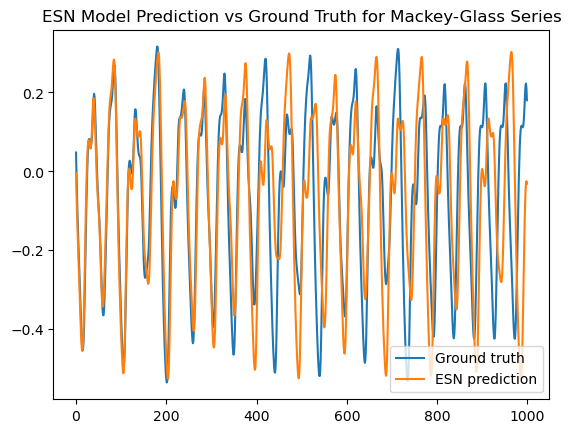

Mean Squared Error for the Mackey-Glass series: 0.03217568326048178


In [16]:
mackey_glass_sim()

In [17]:
def read_data(file_path):
    data = np.loadtxt(file_path)
    X = data[:, 1:]  # features
    y = data[:, 0].astype(int)  # labels
    return X, y

def create_esn_reservoir(X, n_reservoir, sparsity=0.1, spectral_radius=0.99):
    n_input = X.shape[1]
    # 0.25 on W_in is bad for some reason
    # W_in = (np.random.rand(n_reservoir, n_input + 1) - 0.5)
    W_in = np.random.uniform(-1, 1, (n_reservoir, n_input + 1))
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    radius = np.max(np.abs(np.linalg.eigvals(W)))
    W = W * (spectral_radius / radius)
    return W_in, W

def train_esn_regression(X_train, y_train_onehot, W_in, W, n_reservoir):
    X_train_with_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    states = np.zeros((X_train.shape[0], n_reservoir))
    x = np.zeros((n_reservoir,))
    for i in range(X_train_with_bias.shape[0]):
        u = X_train_with_bias[i]
        x = np.tanh(np.dot(W_in, u) + np.dot(W, x))
        states[i] = x
    reg = Ridge(alpha=1.0)
    reg.fit(states, y_train_onehot)
    return reg

def evaluate_esn_regression(X_test, y_test, W_in, W, reg, n_reservoir, encoder):
    X_test_with_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    states = np.zeros((X_test.shape[0], n_reservoir))
    x = np.zeros((n_reservoir,))
    for i in range(X_test_with_bias.shape[0]):
        u = X_test_with_bias[i]
        x = np.tanh(np.dot(W_in, u) + np.dot(W, x))
        states[i] = x
    y_pred_onehot = reg.predict(states)
    y_pred = encoder.inverse_transform(y_pred_onehot)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


X_train, y_train = read_data('dataset/SwedishLeaf_TRAIN.txt')
X_test, y_test = read_data('dataset/SwedishLeaf_TEST.txt')
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

n_reservoir = 800

accuracies = []
for _ in range(10):
    W_in, W = create_esn_reservoir(X_train, n_reservoir)
    reg = train_esn_regression(X_train, y_train_onehot, W_in, W, n_reservoir)
    accuracy = evaluate_esn_regression(X_test, y_test, W_in, W, reg, n_reservoir, encoder)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print(f"Average classification accuracy over 10 runs: {average_accuracy:.2f}")

d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Average classification accuracy over 10 runs: 0.76
